# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 12/4/18

## Path and Imports

In [21]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/REpositories/BitBucket/dic'])
from dic import nurbs
from dic import fileIO
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as sciopt
from scipy import signal

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
ref_image = ref_image.astype('uint8')

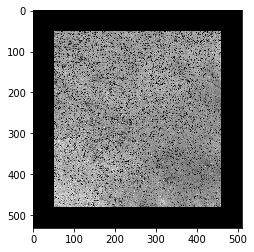

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [5]:
# Define affine warp function
def im_warp(image, warp_mat):
    """
    Apply an affine warp to an image using OpenCV's affine warp function
    
    :param image: image to warped. Grayscale shape: [N x M]. Color shape: [N x M x 3]
    :type image: ndarray
    :param warp_mat: affine warp matrix. Shape: [2, 3]. See OpenCV documentation for details
    :type warp_mat: ndarray
    :return: warped image
    :rtype ndarray
    """
    
    # Sanitize inputs
    if not(image.ndim == 2 or image.ndim == 3):
        raise ValueError("Image input does not have correct dimensions")
        
    if warp_mat.shape != (2, 3):
        raise ValueError("Warp matrix input does not have correct dimension")
    
    # Get shape of image
    rows, cols = image.shape
    
    # Cast the warp matrix as 32 bit floast
    warp_mat = np.float32(warp_mat)
    
    # Warp the image and require the output to be the same size as input
    warped_im = cv2.warpAffine(image, warp_mat, (cols, rows))
    
    return warped_im

In [6]:
# Translate image in x
transx = np.array([[1.0, 0.0, 25.0],
                   [0.0, 1.0, 0.0]])
transx_im = im_warp(ref_image, transx)

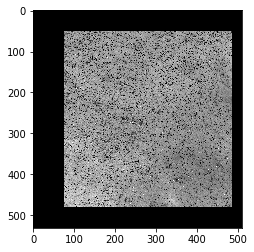

In [7]:
# Display
plt.imshow(transx_im, cmap='gray')

## Let user grab region of interest

### Actually, this doesn't seem to be playing well with the Notebook.

### For now, just going to get the contour (since it's a padded image) and go from there

In [8]:
# For now, this is just a rectangle. More complicated shapes could be used, but that's for later
# r = cv2.selectROI(ref_image)

## Grab contour edges of padded reference image

### Okay, this isn't working either. Some issue with incorrect data type. Puzzler though as images are unit8 as seems to be required.

### Manually specify node locations for now

In [9]:
# Threshold the image first
# retval, ref_threshold = cv2.threshold(ref_image, 5, 255, cv2.THRESH_BINARY)  # Read docs for more detail

In [10]:
# plt.imshow(ref_threshold, cmap='binary')

In [11]:
# Get the contours
# Read docs for more details
# ref_contour_im, ref_contour, ref_heirarch = cv2.findContours(ref_threshold.copy(), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)

## Manually Specify Region of Interest

In [12]:
# Format: [colum index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = [100, 400, 100, 400]

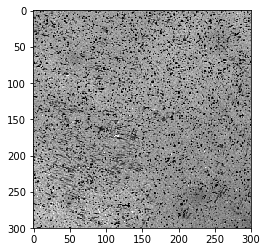

In [13]:
# Extract these regions from ref image and plot
ref_subimage = ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]]
fig, ax = plt.subplots()
ax.imshow(ref_subimage, cmap='gray')
plt.show()

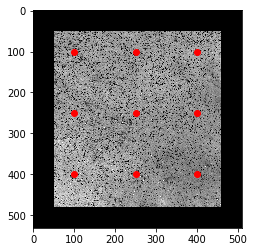

In [14]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x_coord = np.array([subregion_indices[0], subregion_indices[1], np.mean((subregion_indices[0], subregion_indices[1]))])
y_coord = np.array([subregion_indices[2], subregion_indices[3], np.mean((subregion_indices[2], subregion_indices[3]))])
x, y = np.meshgrid(x_coord, y_coord)
nodex = x
nodey = y
nodes = np.column_stack((nodex.flatten(), y.flatten()))
fig, ax = plt.subplots()
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

In [15]:
# Normalize 1D array
def normalize_1d(data_array):
    
    """
    Normalize a 1D data array to range [0, 1].
    
    :param data_array: Input 1d data
    :type data_array: ndarray
    :return: None
    :rtype: None
    """
    # Sanitize input
    if data_array.ndim != 1:
        raise ValueError('Input data must be 1D!')
    
    data_max = np.max(data_array)
    data_min = np.min(data_array)
    
    data_array = data_array - data_min * np.ones(data_array.shape)
    data_array *= 1/(data_max - data_min)
    
    return data_array
    

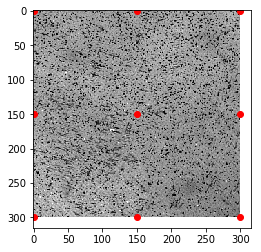

In [16]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x_coord = (np.max(x_coord) - np.min(x_coord)) * normalize_1d(x_coord)
y_coord = (np.max(y_coord) - np.min(y_coord)) * normalize_1d(y_coord)
x, y = np.meshgrid(x_coord, y_coord)
fig, ax = plt.subplots()
ax.imshow(ref_subimage, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

## Correlation Functions 

In [17]:
def discrete_znssd(ref_image, def_image):
    
    """
    Compute the zero normalized sum of square differences (ZNSSD) between two image subsets.
    See Pan et al. Meas Sci Tech 2009 for details
    
    :param ref_image: reference image.
    :type ref_image: ndarray
    :param def_image: deformed image.
    :type def_image: ndarray
    :return: ZNNSD
    :rtype: float
    """
    
    # Sanitize imputs
    if ref_image.ndim != 2:
        raise ValueError('Reference image input must be 2d')
        
    if def_image.ndim != 2:
        raise ValueError('Deformed image input must be 2d')
    
    if ref_image.shape != def_image.shape:
        raise ValueError('Shape of reference and deformed images must match')
    
    # Compute mean of reference image
    fm = np.mean(ref_image)
    
    # compute mean of deformed image
    gm = np.mean(def_image)
    
    # Compute std dev of reference image
    fstd = np.std(ref_image)
    
    # Compute std dev of deformed image
    gstd = np.std(def_image)
    
    # Compute ZNSSD
    
    znssd = 0.0
    
    for i in range(0, ref_image.shape[0]):
        for j in range(0, ref_image.shape[1]):
            znssd += ((ref_image[i, j] - fm) / fstd - (def_image[i, j] - gm) / gstd)**2
    
    return znssd
    

In [18]:
# Could just do this sweeps
def minfun(delta, *args):
    
    """
    Function for scipy minimizer to minimize

    :param delta: 1D arrary of rigid body rotations
    :type delata: ndarray
    :return: ZNSSD of deformed ref and deformed image
    :rtype: float
    """
    # TODO: Type checks
    
    # Get deltas
    dx = delta[0]
    dy = delta[1]
    
    # Deform the nodes
    nodes_ref = args[0]
    # Copy and update reference image locations only
    nodes_def = np.copy(nodes_ref) # Copy
    nodes_def[:, 0] += dx * np.ones(len(nodes_def))
    nodes_def[:, 1] += dy * np.ones(len(nodes_def))
    
    
    # Min/max nodes in x/y for ref and def
    # TODO: Refactor
    # Round values down as the step size must be interger valued
    minx_ref = np.min(nodes_ref[:, 0]).astype('int')
    miny_ref = np.min(nodes_ref[:, 1]).astype('int')
    maxx_ref = np.max(nodes_ref[:, 0]).astype('int')
    maxy_ref = np.max(nodes_ref[:, 1]).astype('int')
    
    minx_def = np.min(nodes_def[:, 0]).astype('int')
    miny_def = np.min(nodes_def[:, 1]).astype('int')
    maxx_def = np.max(nodes_def[:, 0]).astype('int')
    maxy_def = np.max(nodes_def[:, 1]).astype('int')
    
    # Get ref and def images
    ref_im = args[1]
    ref_subset = ref_im[miny_ref:maxy_ref, minx_ref:maxx_ref]
    def_im = args[2]
    def_subset = def_im[miny_def:maxy_def, minx_def:maxx_def]
    
    # Compute ZNSSD
    znssd = discrete_znssd(ref_subset, def_subset)
    
    return znssd
    

## Wrap this minfun in scipy optimization library

In [19]:
def callbackF(xk, *args):
    print('{0: 0.5f} {1: 0.5f} {2: 0.5}'.format(xk[0], xk[0], minfun(xk)))

In [20]:
args = (nodes, ref_image, transx_im)
x0 = [20, 0]
foo = sciopt.OptimizeResult
result = sciopt.minimize(minfun, x0, args=args, method='Powell', options={'disp':True})

Optimization terminated successfully.
         Current function value: 168147.281204
         Iterations: 2
         Function evaluations: 180


In [25]:
foo = signal.cspline2d(ref_image)